# Automatically Adding Products To A User's Shopping Cart

A recent business model trend is to automatically deliver products to customers and allow them to return those that they are not interested in. Stitch Fix is one of the most famous of the subscription box model businesses. After submitting a smorgasbord of initial information about body type and personal preferences, a Stitch Fix customer will be sent a package full of new clothes. The customer is then free to send back any clothes they don’t like and they are charged for the items they keep (plus a service fee).

This idea might sound novel, but companies have been doing this for a long time via “no-commitment” subscription models. For example, Hewlett Packard will happily deliver ink for your printer at a prescribed rate. You can subscribe to certain products on Amazon. Hello Fresh will deliver you food. The difference between no-commitment and subscription box models is that if the customer is on the wrong plan (for example, they are receiving too much ink), they are likely to cancel. It is in HP’s interest to deliver ink at the right rate to maximize the customer lifetime value.

I want to stress how impressive this challenge is. Here, an agent with no human intervention can automatically send you products and iteratively learn your preferences. You will receive items when you need them without you ordering them. Even better, the agent knows what items you might like, even though you have never thought of buying them yourself. From the perspective of a marketplace, this demonstrates why RL could be so lucrative. Vendors can sell you more stuff and you will be genuinely happy that they have!

Covid has sparked demand for online shopping, no more so than online groceries. Yet when I order my groceries, it takes an inordinate amount time to add all of my items to my basket, even with all the “lists” and “favourties” that companies are offering.

What about, instead of placing that burden on the customer, accept that burden and design a system to learn what a customer wants and to order the items with zero user interaction. In an ideal scenario the customers will be suprised but happy to receive an unnanounced order, right as they are running out of crucial groceries.

RL is a potential solution to this problem. By allowing an agent to actively send products and learning from refusals, an agent might be able to pick the right items at the right time.

Obviously in the real world you should constrain the problem and the potential actions to ensure they are safe and robust, but I won’t detail that here.

For this experiment I will be using a custom environment based upon some real life data from InstaCart. Find out more about that data in the gym-shopping-cart repository.

## Setup

### Installations

In [ ]:
!pip install pygame==1.9.6 pandas==1.0.5 matplotlib==3.2.1 gym==0.17.3
!pip install gym_shopping_cart
!pip install --upgrade git+git://github.com/david-abel/simple_rl.git@77c0d6b910efbe8bdd5f4f87337c5bc4aed0d79c

### Imports

In [8]:
from typing import Callable
from collections import namedtuple
import numpy as np
import pandas as pd
from scipy.optimize import check_grad
from pathlib import Path

from simple_rl.tasks import *
from simple_rl.run_experiments import *
from simple_rl.tasks.gym.GymStateClass import GymState
import gym_shopping_cart
from gym_shopping_cart.data.parser import InstacartData

from simple_rl.agents import *

import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

### Dataset

In [ ]:
# !wget -N https://s3.eu-west-2.amazonaws.com/assets.winder.ai/data/instacart_online_grocery_shopping_2017_05_01.tar.gz
# !wget https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz

## Agents

This experiment uses the eligibility traces implementation of the actor-critic algorithm. I’m unsure whether this is better than a simpler 1-step actor-critic implementation – you can test this yourself. I’ve left the debugging code in to allow you to peak inside, if you’re interested.

Below that I’ve also included an “order everything” and random agents as baselines.

In [10]:
class EligibilityActorCritic(PolicyGradientAgent):
    def __init__(self, actions, α_θ=0.1, α_w=0.01, prefix="", λ_w=0.1, λ_θ=0.1):
        self.α_θ = α_θ
        self.α_w = α_w
        self.λ_w = λ_w
        self.λ_θ = λ_θ
        self.γ = 0.99
        self.actions = actions
        PolicyGradientAgent.__init__(
            self, name=prefix + "eligibility_actor_critic", actions=actions
        )
        self.reset()

    @staticmethod
    def v(w, S):
        return np.dot(w.T, S)

    @staticmethod
    def Δv(w, S):
        return S

    @staticmethod
    def logistic(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def π(θ, s):
        return EligibilityActorCritic.logistic(np.dot(θ.T, s))

    @staticmethod
    def Δ(θ, s):
        return s - s * EligibilityActorCritic.logistic(np.dot(θ.T, s))

    @staticmethod
    def π_vec(θ, s):
        return np.array(
            [
                EligibilityActorCritic.logistic(np.dot(θ[:, i].T, s))
                for i in range(θ.shape[1])
            ]
        )

    @staticmethod
    def π_mat(θ, s):
        return EligibilityActorCritic.logistic(np.dot(θ.T, s))

    @staticmethod
    def Δ_vec(θ, s):
        return np.array(
            [
                s - s * EligibilityActorCritic.logistic(np.dot(θ[:, i].T, s))
                for i in range(θ.shape[1])
            ]
        )

    @staticmethod
    def Δ_mat(θ, s):
        return s[:, np.newaxis] - np.outer(
            s, EligibilityActorCritic.logistic(np.dot(θ.T, s))
        )

    def update(self, state, action, reward, next_state, terminal: bool):
        v = self.v(self.w, state)
        if terminal:
            δ = reward + self.γ * 0 - v
        else:
            δ = reward + self.γ * self.v(self.w, next_state) - v
        self.delta_buffer.append(δ)
        self.z_w = self.γ * self.λ_w * self.z_w + self.Δv(self.w, state)
        self.w += self.α_w * δ * self.z_w
        self.z_θ[:, action > 0] = (
            self.γ * self.λ_θ * self.z_θ[:, action > 0]
            + self.I * EligibilityActorCritic.Δ_mat(self.θ, state)[:, action > 0]
        )
        self.z_θ[:, action == 0] = self.γ * self.λ_θ * self.z_θ[:, action == 0]
        self.θ += self.α_θ * δ * self.z_θ
        self.I *= self.γ

    def act(self, state, reward):
        if self.θ is None:
            self.θ = np.zeros((len(state.data), len(self.actions)))
        if self.z_θ is None:
            self.z_θ = np.zeros((len(state.data), len(self.actions)))
        if self.w is None:
            self.w = np.zeros(len(state.data))
        if self.z_w is None:
            self.z_w = np.zeros(len(state.data))
        self.data_buffer.append(state.data)
        # print(state.data.shape, state.data[0])
        # state.data = np.ones(state.data.shape)
        # reward = 1
        if self.previous_pair is not None:
            self.update(
                self.previous_pair.state,
                self.previous_pair.action,
                reward,
                state.data,
                state.is_terminal(),
            )
        π = EligibilityActorCritic.π_mat(self.θ, state)
        # print(π[0])
        action = np.array([np.random.choice(a=(0, 1), p=(1 - p, p)) for p in π])
        self.previous_pair = Pair(state.data, action)
        self.t += 1
        return action

    def reset(self):
        self.θ = None
        self.w = None
        self.delta_buffer = []
        self.data_buffer = []
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        # print(
        #     np.array2string(
        #         self.θ[:, 0], formatter={"float_kind": lambda x: "%.2f" % x}
        #     )
        # )
        # print(
        #     "{:2d}\t{:+.2f}\t{:+.2f}\t{:+.2f}\t{:+.2f}\t{:+.2f}".format(
        #         self.episode_number,
        #         np.mean(self.θ),
        #         np.sum(np.abs(self.θ)),
        #         np.std(self.θ),
        #         np.min(self.θ),
        #         np.max(self.θ),
        #     )
        # )
        # print(np.mean(self.delta_buffer))
        # print(np.array(self.data_buffer).mean(axis=0).shape)
        # print(np.array(self.data_buffer).mean(axis=0))
        self.data_buffer = []
        self.delta_buffer = []
        self.data_buffer = []
        self.z_θ = None
        self.z_w = None
        self.I = 1
        self.t = 0
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)


class AllOnesAgent(Agent):
    """ Custom random agent for multi-binary actions. """

    def __init__(self, actions, prefix=""):
        Agent.__init__(self, name=prefix + "All ones", actions=actions)

    def act(self, state, reward):
        return np.ones((len(self.actions),))


class MultiBinaryRandomAgent(Agent):
    """ Custom random agent for multi-binary actions. """

    def __init__(self, actions, prefix=""):
        Agent.__init__(self, name=prefix + "Random", actions=actions)

    def act(self, state, reward):
        return np.random.choice([1, 0], size=len(self.actions), p=[0.5, 0.5])

## Helper Functions
Next I need a few helper functions, relating to the chosen policy. I’m using a softmax and a hand-derived gradient calculation. You could swap this out for a symbolic or auto-diff approach. Note that I’m using scipy’s check_grad method to test that the gradient is correct when doing a finite difference calculation.

In [11]:
def softmax(v):
    exps = np.exp(v)
    sum = np.sum(exps)
    return exps / sum


def softmax_grad(softmax):
    s = softmax.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)


def test_differential():
    # Tests that the gradients have been calculated correctly
    s = np.ones((4,))
    θ_test = -1 * np.ones((4, 2))
    test_values = [-1 * np.ones((4, 2)), 0 * np.ones((4, 2)), 1 * np.ones((4, 2))]
    for θ_test in test_values:
        for a in range(θ_test.shape[1]):
            val = check_grad(
                lambda θ: np.log(EligibilityActorCritic.π(θ, s)),
                lambda θ: EligibilityActorCritic.Δ(θ, s),
                θ_test[:, a],
            )
            assert val < 0.0001
    print(
        np.log(EligibilityActorCritic.π(θ_test[:, 0], s)),
        np.log(EligibilityActorCritic.π(θ_test[:, 1], s)),
    )
    print(np.log(EligibilityActorCritic.π_vec(θ_test, s)))
    print(np.log(EligibilityActorCritic.π_mat(θ_test, s)))
    print(
        EligibilityActorCritic.Δ(θ_test[:, 0], s),
        EligibilityActorCritic.Δ(θ_test[:, 1], s),
    )
    print(EligibilityActorCritic.Δ_vec(θ_test, s))
    print(EligibilityActorCritic.Δ_mat(θ_test, s))

Step = namedtuple("Step", ["pair", "reward"])
Pair = namedtuple("Pair", ["state", "action"])

test_differential()

-0.01814992791780973 -0.01814992791780973
[-0.01814993 -0.01814993]
[-0.01814993 -0.01814993]
[0.01798621 0.01798621 0.01798621 0.01798621] [0.01798621 0.01798621 0.01798621 0.01798621]
[[0.01798621 0.01798621 0.01798621 0.01798621]
 [0.01798621 0.01798621 0.01798621 0.01798621]]
[[0.01798621 0.01798621]
 [0.01798621 0.01798621]
 [0.01798621 0.01798621]
 [0.01798621 0.01798621]]


## Running The Experiment: A Single Customer
Now the differential test checks out, we can run the experiment. I’m using the eligibility AC algorithm on a single user. The single customer test data comes straight from the library. This path might change if you use the code somewhere else.

In [12]:
n_instances = 1
n_episodes = 50
max_products = 15

In [16]:
!python -c "import setuptools as _; print(_.__path__)"

['/usr/local/lib/python3.7/dist-packages/setuptools']


In [19]:
!ls -al /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/data

total 44
drwxr-sr-x 4 root staff  4096 Oct 17 11:07 .
drwxr-sr-x 5 root staff  4096 Oct 17 11:05 ..
-rw-r--r-- 1 root staff     0 Oct 17 11:05 __init__.py
drwxr-xr-x 2  501 staff  4096 Dec 29  2019 instacart_2017_05_01
-rw-r--r-- 1 root staff  8746 Oct 17 11:05 parser.py
drwxr-sr-x 2 root staff  4096 Oct 17 11:05 __pycache__
-rw-r--r-- 1 root staff 15189 Oct 17 11:05 test_data.tar.gz


In [20]:
# Single test user
gym_mdp = GymMDP(env_name="SimpleShoppingCart-v0", render=False)
gym_mdp.env.data = InstacartData(
    gz_file=Path(
        "/usr/local/lib/python3.7/dist-packages/gym_shopping_cart/data/test_data.tar.gz"
    ),
    max_products=max_products,
)
gym_mdp.init_state = GymState(gym_mdp.env.reset())
actions = range(gym_mdp.env.action_space.n)

agent = EligibilityActorCritic(actions, prefix="simple_shopping_single_")
random = MultiBinaryRandomAgent(actions, prefix="simple_shopping_single_")
run_agents_on_mdp(
    [agent, random],
    gym_mdp,
    instances=n_instances,
    episodes=n_episodes,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)

Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01
Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/data/instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_single_eligibility_actor_critic,0
	simple_shopping_single_Random,1
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_single_eligibility_actor_critic is learning.
  Instance 1 of 1.

simple_shopping_single_Random is learning.
  Instance 1 of 1.


--- TIMES ---
simple_shopping_single_eligibility_actor_critic agent took 14.77 seconds.
simple_shopping_single_Random agent took 12.47 seconds.
-------------

	simple_shopping_single_eligibility_actor_critic: 32.0 (conf_interv: 0.0 )
	simple_shopping_single_Random: -181.0 (conf_interv: 0.0 )


## Plot utils

In [22]:
def plot(experiment_name, data_files, cutoff=None, y_lim=None, colors=None, y_label="Average Reward (50 runs)"):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for j, (name, data_file) in enumerate(data_files):
        df = pd.read_csv(data_file, header=None).transpose()
        if cutoff:
            df = df.truncate(after=cutoff)
        x = df.index.values
        y = df.values
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        ax.plot(
            x,
            y,
            label=name,
        )

    ax.set_xlabel("Episode")
    ax.set_ylabel(y_label)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.legend(frameon=False, loc="center right", ncol=1, handlelength=2)
    plt.show()

## Single Customer Results
Take a look at the results below. After 30 or so interactions with the customer, the agent has learnt what they order and what they like. The number of products being returned is now low enough so that the customer keeps more than they return.

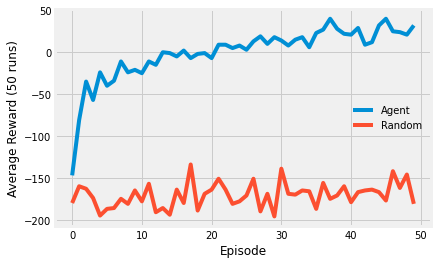

In [23]:
ac_csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_single_eligibility_actor_critic.csv"
random_csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_single_Random.csv"
data_files = [("Agent", ac_csv), ("Random", random_csv)]
plot("simple_shopping_single_user", data_files, cutoff=100)